# Import Python modules and connect CAS

In [1]:
from swat import *
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import sys
import math

from dlpy import Model, Sequential
from dlpy.model import *
from dlpy.layers import *
from dlpy.applications import *
from dlpy.utils import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split
from dlpy.model import Optimizer

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

In [3]:
s = CAS('host_name', port_number)
s.sessionprop.setsessopt(caslib='CASUSER', timeout=31535000)

NOTE: 'CASUSER(username)' is now the active caslib.


+ Elapsed: 0.000205s, user: 0.000142s, sys: 5.3e-05s, mem: 0.274mb

# Load the training and testing data that contain spectrogram images

In [4]:
s.addCasLib(path='/data/spoken_language_identification', caslib='data', subdirs=True)

NOTE: 'data' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'data'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,data,PATH,,/data/spoken_language_identification/,,1.0,1.0,1.0,0.0,0.0,0.0


In [5]:
s.loadTable(caslib='data', path='train_spectrogram.sashdat')

NOTE: Cloud Analytic Services made the file train_spectrogram.sashdat available as table TRAIN_SPECTROGRAM in caslib data.


[caslib]

 'data'

[tableName]

 'TRAIN_SPECTROGRAM'

[casTable]

 CASTable('TRAIN_SPECTROGRAM', caslib='data')

+ Elapsed: 0.151s, user: 0.0462s, sys: 0.104s, mem: 17.2mb

In [6]:
s.loadTable(caslib='data', path='test_spectrogram.sashdat')

NOTE: Cloud Analytic Services made the file test_spectrogram.sashdat available as table TEST_SPECTROGRAM in caslib data.


[caslib]

 'data'

[tableName]

 'TEST_SPECTROGRAM'

[casTable]

 CASTable('TEST_SPECTROGRAM', caslib='data')

+ Elapsed: 0.00234s, user: 0.000215s, sys: 0.00145s, mem: 0.827mb

In [7]:
# load as ImageTable
train_data = ImageTable.from_table(s.CASTable('train_spectrogram'))

In [8]:
train_data.label_freq

,Level,Frequency
de,1,24360
en,2,24360
es,3,24360


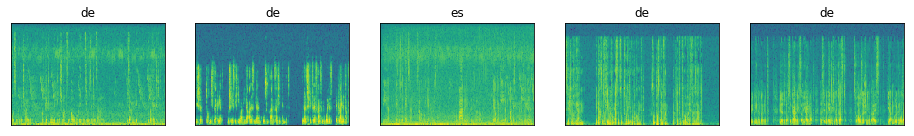

In [9]:
train_data.show(randomize=True)

In [10]:
train_data.image_summary

jpg                 73080
minWidth             1800
maxWidth             1800
minHeight            1200
maxHeight            1200
meanWidth            1800
meanHeight           1200
mean1stChannel    119.994
min1stChannel          24
max1stChannel         255
mean2ndChannel     170.18
min2ndChannel           1
max2ndChannel         255
mean3rdChannel    58.7765
min3rdChannel          30
max3rdChannel         255
dtype: object

In [11]:
# resize all images to 600*400
train_data.resize(width=600, height=400)

In [12]:
train_data.image_summary

jpg                 73080
minWidth              600
maxWidth              600
minHeight             400
maxHeight             400
meanWidth             600
meanHeight            400
mean1stChannel    119.977
min1stChannel           0
max1stChannel         255
mean2ndChannel    170.211
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    58.7051
min3rdChannel           0
max3rdChannel         255
dtype: object

In [13]:
test_data = ImageTable.from_table(s.CASTable('test_spectrogram'))

In [14]:
test_data.resize(width=600, height=400)

In [15]:
test_data.image_summary

jpg                   540
minWidth              600
maxWidth              600
minHeight             400
maxHeight             400
meanWidth             600
meanHeight            400
mean1stChannel    121.593
min1stChannel           0
max1stChannel         189
mean2ndChannel    168.186
min2ndChannel           0
max2ndChannel         246
mean3rdChannel    56.5064
min3rdChannel           0
max3rdChannel         255
dtype: object

In [16]:
test_data.label_freq

,Level,Frequency
de,1,180
en,2,180
es,3,180


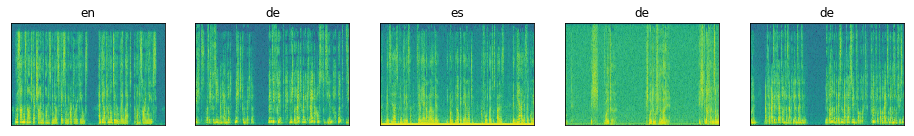

In [17]:
test_data.show(randomize=True)

# Specify  ResNet18 model

In [18]:
modelName = 'ResNet18'
model = ResNet18_Caffe(s, model_table=modelName, 
                    n_classes=3, 
                    width=600, height=400,   
                    scale=1/255
                    ,random_flip='HV'
                    )

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Pooling layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [19]:
# check the input layer options by converting the model into the functional one
# you can easily change the ResNet18 model using functional APIs
model_head_func = model.to_functional_model(stop_layers=model.layers[-1])

In [20]:
model_head_func.layers[0].config['dropout']=0.0

In [21]:
model_head_func.layers[0].config

{'n_channels': 3,
 'width': 600,
 'height': 400,
 'nominals': None,
 'std': None,
 'scale': 0.00392156862745098,
 'offsets': [0, 0, 0],
 'dropout': 0.0,
 'random_flip': 'HV',
 'random_crop': None,
 'random_mutation': None,
 'norm_stds': None}

In [22]:
inp = Input(**model_head_func.layers[0].config)
x = model_head_func(inp)
output = OutputLayer(n=3)(x)

model = Model(s, inp, output)
model.compile()

NOTE: Model compiled successfully.


In [23]:
model.count_params()

11182275

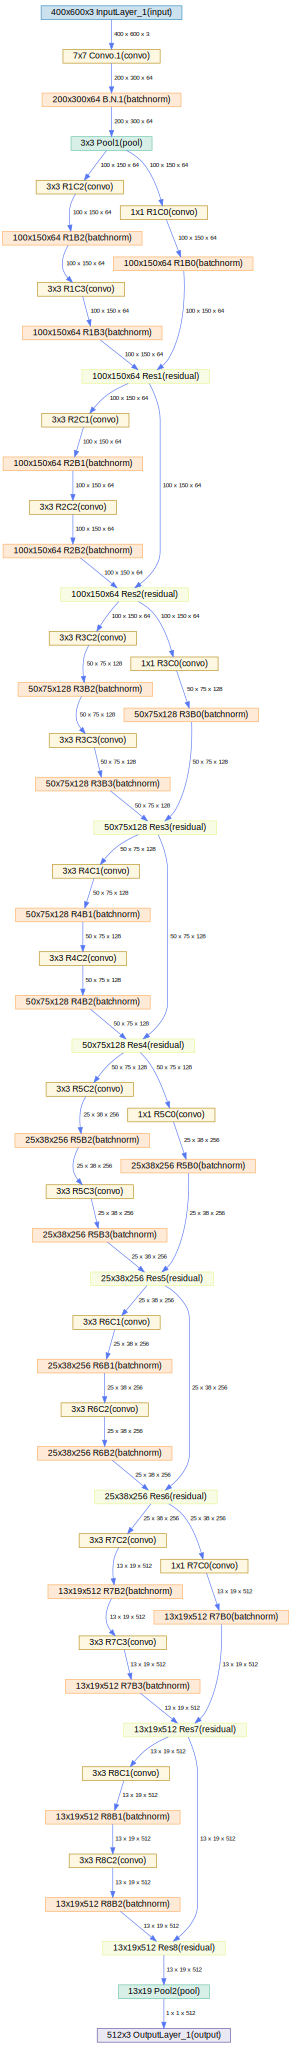

In [24]:
model.plot_network()

# Training

In [25]:
train, valid=two_way_split(train_data)

In [26]:
train.numrows()

[numrows]

 58464

+ Elapsed: 0.000309s, user: 0.000285s, sys: 6e-06s, mem: 0.414mb

In [27]:
nThread=16

solver = MomentumSolver(lr_scheduler=StepLR(learning_rate=0.01, step_size=20, gamma=0.4), 
                        clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=8, log_level=2, max_epochs=60, reg_l2=0.0001)
gpu = Gpu(devices=[1])

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [28]:
train_res = model.fit(data=train, 
                               valid_table=valid,
                               n_threads=nThread, record_seed=13009, optimizer=optimizer,
                               gpu=gpu,
                               force_equal_padding=True
                               , train_from_scratch=True
                              )

NOTE: Inputs=_image_ is used
NOTE: Training from scratch.
NOTE: Using dlgrd009.unx.sas.com: 1 out of 4 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 11182275.
NOTE:  The approximate memory cost is 1217.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       2.81 (s).
NOTE:  The total number of threads on each worker is 16.
NOTE:  The total mini-batch size per thread on each worker is 8.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      3
NOTE:  Levels for the target variable:
NOTE:  Level      0: de
NOTE:  Level      1: en
NOTE:  Level      2: es
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  0          0.01          0.9272     0.4396 

In [29]:
train_res

,Descr,Value
0,Model Name,model_2izl0n
1,Model Type,Convolutional Neural Network
2,Number of Layers,54
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,21
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,21
9,Number of Residual Layers,8


# Assess the Model

In [30]:
model.evaluate(data=test_data, gpu=dict(devices=1), model_task='CLASSIFICATION')

NOTE: Due to data distribution, miniBatchSize has been limited to 7.
NOTE: Using dlgrd009.unx.sas.com: 1 out of 4 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           540
 1  Number of Observations Used           540
 2  Misclassification Error (%)      2.592593
 3                   Loss Error      0.074265

[OutputCasTables]

   casLib              Name  Rows  Columns  \
 0   data  Valid_Res_9P3jz7   540       10   
 
                                       casTable  
 0  CASTable('Valid_Res_9P3jz7', caslib='data')  

+ Elapsed: 7.33s, user: 15s, sys: 5.4s, mem: 3.71e+03mb

In [31]:
test_result_table = model.valid_res_tbl

In [32]:
from dlpy.metrics import (accuracy_score, confusion_matrix, plot_roc, 
                          plot_precision_recall, roc_auc_score, f1_score, average_precision_score)

In [33]:
# Show the confusion matrix
display(confusion_matrix(test_result_table['_label_'], test_result_table['I__label_']))

,de,en,es
_label_,,,
de,176.0,3.0,1.0
en,1.0,173.0,6.0
es,3.0,0.0,177.0


In [34]:
# Calculate the average f1 score
f1 = 0
for i in 0, 1, 2:
    f1 = f1 + f1_score(test_result_table['_label_'], test_result_table['I__label_'], pos_label=i)
print('the f1 score is {:.6f}'.format(f1/3))

the f1 score is 0.974072


In [35]:
# Calculate the accuracy score
acc_score = accuracy_score(test_result_table['_label_'], test_result_table['I__label_'])
print('the accuracy score is {:.6f}'.format(acc_score))

the accuracy score is 0.974074


## Deploy model

In [36]:
model.deploy(output_format='table', 
                      path='/data/spoken_language_identification')

NOTE: Model table saved successfully.


In [37]:
model.deploy(output_format='astore', 
                      path=r'\\local_dir\spoken_language_identification')

NOTE: Model astore file saved successfully.


In [38]:
s.endsession()

+ Elapsed: 0.000142s, user: 0.000117s, sys: 1.4e-05s, mem: 0.203mb

In [ ]:
#s.shutdown()